<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/01_exploration/%5BE-17%5Dexploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🎄 EXPLORATION 17**  

# **🌲 EXPLORATION 17-1 : Movielens 영화 SBR**

## **🌿 01_데이터 준비**

### **🍃 01-1_필요 라이브러리 import**

In [ ]:
import datetime as dt
from pathlib import Path
import os
from datetime import datetime

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

### **🍃 01-2_필요 데이터 import**

In [ ]:
data_path = Path('C:/Users/96452/00_work/E-17/data/') 
train_path = data_path / 'ratings.dat'

### **🍃 01-3_필요 데이터 import**

In [ ]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

### **🍃 01-4_데이터 정렬**

- **UserId, Time 순으로 정렬**


In [ ]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### **🍃 01-5_데이터 확인**

- **유저 수, 아이템 수 확인**

In [ ]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## **🌿 02_데이터 전처리**

### **🍃 02-1_세션 길이 확인**

- **해당 유저의 세션 내 클릭 횟수 확인**

In [ ]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

- **세션 길이 정보 확인**

In [ ]:
print(f'각 세션 길이의 중앙값: {session_length.median()}')
print(f'각 세션 길이의 평균값: {session_length.mean()}')
print(f'각 세션 길이의 최솟값: {session_length.min()}')
print(f'긱 세션 길이의 최댓값: {session_length.max()}')
print(f'99.9% 세션의 길이: {session_length.quantile(0.999)}')

각 세션 길이의 중앙값: 96.0
각 세션 길이의 평균값: 165.5975165562914
각 세션 길이의 최솟값: 20
긱 세션 길이의 최댓값: 2314
99.9% 세션의 길이: 1343.181000000005


### **🍃 02-2_세션 길이 분포 누적합**

- **세션 길이 기준(하위 99.9%) 분포 누적합**

In [ ]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

- **세션 길이 기준(하위 99.9%) 분포 누적합 시각화**

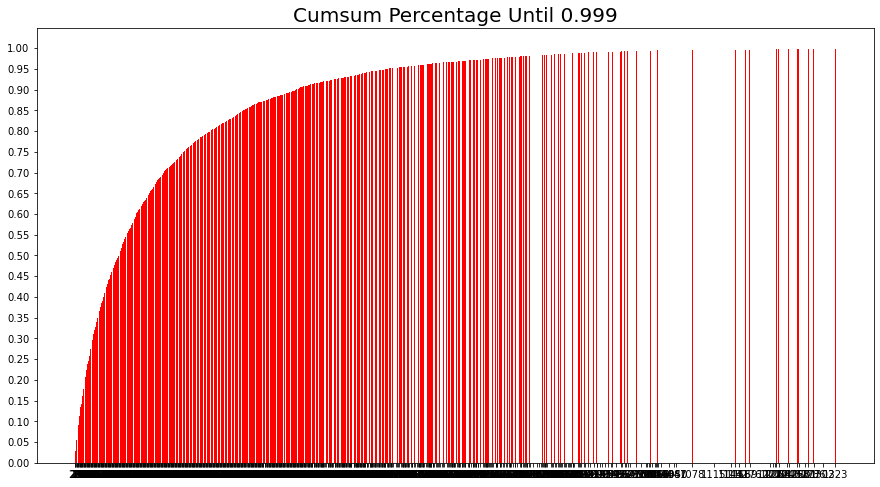

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### **🍃 02-3_세션 시간 확인**

- **세션 시간 확인**

In [ ]:
change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43


- **가장 오래된 세션, 가장 최근의 세션 확인**

In [ ]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-26 08:05:32
2003-03-01 02:49:50


### **🍃 02-4_평점 확인**

- **평점 분포 시각화**

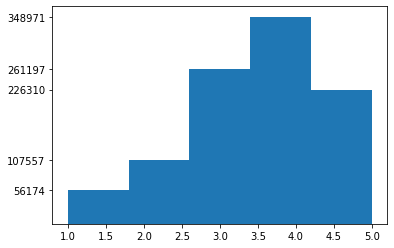

In [ ]:
plt.hist(data['Rating'], bins=5)
plt.yticks(data['Rating'].value_counts())
plt.show()

- **4점 이하의 평점 제거**

In [ ]:
data = data[data['Rating']>=4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575281 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   UserId  575281 non-null  int32         
 1   ItemId  575281 non-null  int32         
 2   Rating  575281 non-null  int32         
 3   Time    575281 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3)
memory usage: 15.4 MB


### **🍃 02-5_데이터 정제**

In [ ]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

- **세션이 짧은 경우 삭제**

In [ ]:
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

- **비인기 영화 삭제**

In [ ]:
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

- **데이터 확인**

In [ ]:
data = cleanse_recursive(data, shortest=5, least_click=15)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
36,1,1836,5,2001-01-01 07:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 23:39:27
999923,6040,232,5,2001-08-10 23:39:58
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04


## **🌿 03_데이터 분리**

### **🍃 03-1_데이터 순서 정렬**

- **데이터 시간 순으로 정렬**

In [ ]:
data = data.sort_values('Time')

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-26 08:05:32
999873,6040,593,5,2000-04-26 08:05:54
1000153,6040,2384,4,2000-04-26 08:05:54
1000007,6040,1961,4,2000-04-26 08:06:17
1000192,6040,2019,5,2000-04-26 08:06:17
999920,6040,213,5,2000-04-26 08:07:36
999980,6040,3505,4,2000-04-26 08:07:36
999967,6040,3111,5,2000-04-26 08:07:36
999884,6040,912,5,2000-04-26 08:09:51
999888,6040,919,5,2000-04-26 08:09:51


### **🍃 03-2_Train, Test, Valid 데이터 분리**

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [ ]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

### **🍃 03-3_Train, Test, Valid 데이터 확인**

- **데이터 확인 함수 생성**

In [ ]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

- **데이터 확인**

In [ ]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 558307
	 Sessions: 6031
	 Items: 2562
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-03-05 12:58:17

* valid Set Stats Info
	 Events: 6211
	 Sessions: 365
	 Items: 1808
	 First Time : 2002-03-05 13:38:49
	 Last Time : 2002-09-01 13:20:59

* test Set Stats Info
	 Events: 4729
	 Sessions: 311
	 Items: 1512
	 First Time : 2002-09-02 04:43:16
	 Last Time : 2003-03-01 02:49:50



### **🍃 03-4_인덱싱**

- **train data를 기준으로 인덱싱**

In [ ]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## **🌿 04_미니 배치 구성**

### **🍃 04-1_SessionDataset**

- **SessionDataset 구성**

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

- **SessionDataset 데이터 확인**

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-26 08:05:32,0
999873,6040,593,5,2000-04-26 08:05:54,1
1000153,6040,2384,4,2000-04-26 08:05:54,2
1000007,6040,1961,4,2000-04-26 08:06:17,3
1000192,6040,2019,5,2000-04-26 08:06:17,4
999920,6040,213,5,2000-04-26 08:07:36,5
999980,6040,3505,4,2000-04-26 08:07:36,6
999967,6040,3111,5,2000-04-26 08:07:36,7
999884,6040,912,5,2000-04-26 08:09:51,8
999888,6040,919,5,2000-04-26 08:09:51,9


- **SessionDataset 클릭 옵셋**

In [ ]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 558008, 558098, 558307])

- **SessionDataset 세션 인덱스**

In [ ]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6028, 6029, 6030])

### **🍃 04-2_SessionDataLoader**

- **SessionDataLoader 구성**

In [ ]:
class SessionDataLoader:

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

- **SessionDataLoader 데이터 확인**

In [ ]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-26 08:05:32,0
999873,6040,593,5,2000-04-26 08:05:54,1
1000153,6040,2384,4,2000-04-26 08:05:54,2
1000007,6040,1961,4,2000-04-26 08:06:17,3
1000192,6040,2019,5,2000-04-26 08:06:17,4
999920,6040,213,5,2000-04-26 08:07:36,5
999980,6040,3505,4,2000-04-26 08:07:36,6
999967,6040,3111,5,2000-04-26 08:07:36,7
999884,6040,912,5,2000-04-26 08:09:51,8
999888,6040,919,5,2000-04-26 08:09:51,9


- **SessionDataLoader 데이터 인덱싱 확인**

In [ ]:
iter_ex = iter(tr_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  45 116 138]
Label Item Idx are :       [  1  46 117 139]
Previous Masked Input Idx are []


## **🌿 05_모델 구성**

### **🍃 05-1_모델 생성**

In [ ]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

### **🍃 05-2_하이퍼 파라미터**

In [ ]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [ ]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

### **🍃 05-3_모델 확인**

In [ ]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 2562)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    392100    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 2562)               130662    
Total params: 522,762
Trainable params: 522,762
Non-trainable params: 0
_________________________________________________________________


### **🍃 05-4_MRR 지표**

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

### **🍃 05-4_Recall 지표**

In [ ]:
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### **🍃 05-5_Train 함수 생성**

In [ ]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

### **🍃 05-5_파라미터 초기화 함수 생성**

In [ ]:
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)

### **🍃 05-6_Metric 함수 생성**

In [ ]:
def get_metrics(data, model, args, k: int): 
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### **🍃 05-7_모델 테스트 함수 생성**

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

## **🌿 06_1차 학습**

### **🍃 06-1_1차 모델 학습**

In [ ]:
train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:03<00:32,  1.65s/it]


	 - Recall@20 epoch 1: 0.054688
	 - MRR@20    epoch 1: 0.008049



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.48s/it]


	 - Recall@20 epoch 2: 0.066406
	 - MRR@20    epoch 2: 0.011408



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.43it/s]


	 - Recall@20 epoch 3: 0.066406
	 - MRR@20    epoch 3: 0.015687



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.48it/s]


	 - Recall@20 epoch 4: 0.074219
	 - MRR@20    epoch 4: 0.019676



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.42it/s]


	 - Recall@20 epoch 5: 0.070312
	 - MRR@20    epoch 5: 0.018829



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.50s/it]


	 - Recall@20 epoch 6: 0.072266
	 - MRR@20    epoch 6: 0.017011



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.42s/it]


	 - Recall@20 epoch 7: 0.078125
	 - MRR@20    epoch 7: 0.017413



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.43it/s]


	 - Recall@20 epoch 8: 0.085938
	 - MRR@20    epoch 8: 0.019528



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.45s/it]


	 - Recall@20 epoch 9: 0.080078
	 - MRR@20    epoch 9: 0.018892



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.48s/it]


	 - Recall@20 epoch 10: 0.078125
	 - MRR@20    epoch 10: 0.018500



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.56it/s]


	 - Recall@20 epoch 11: 0.076172
	 - MRR@20    epoch 11: 0.018198



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.51it/s]


	 - Recall@20 epoch 12: 0.076172
	 - MRR@20    epoch 12: 0.017314



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.48it/s]


	 - Recall@20 epoch 13: 0.082031
	 - MRR@20    epoch 13: 0.017556



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.53it/s]


	 - Recall@20 epoch 14: 0.080078
	 - MRR@20    epoch 14: 0.017497



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.60it/s]


	 - Recall@20 epoch 15: 0.080078
	 - MRR@20    epoch 15: 0.016781



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.42s/it]


	 - Recall@20 epoch 16: 0.082031
	 - MRR@20    epoch 16: 0.017826



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.60it/s]


	 - Recall@20 epoch 17: 0.082031
	 - MRR@20    epoch 17: 0.016525



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.57it/s]


	 - Recall@20 epoch 18: 0.078125
	 - MRR@20    epoch 18: 0.016508



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.54it/s]


	 - Recall@20 epoch 19: 0.076172
	 - MRR@20    epoch 19: 0.017004



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.57it/s]

	 - Recall@20 epoch 20: 0.078125
	 - MRR@20    epoch 20: 0.016918



### **🍃 06-2_1차 모델 학습 결과**

In [ ]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:06,  2.42it/s]

	 - Recall@20: 0.066406
	 - MRR@20: 0.012386



## **🌿 07_2차 학습**

- **Learning rate 변경**

### **🍃 07-1_2차 모델 학습**

In [ ]:
args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.3, lr=0.01, epochs=30, k=20)
train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.40it/s]


	 - Recall@20 epoch 1: 0.080078
	 - MRR@20    epoch 1: 0.017481



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.61it/s]


	 - Recall@20 epoch 2: 0.080078
	 - MRR@20    epoch 2: 0.016570



Evaluation:   9%|▉         | 2/22 [00:02<00:26,  1.34s/it]


	 - Recall@20 epoch 3: 0.078125
	 - MRR@20    epoch 3: 0.016975



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.50it/s]


	 - Recall@20 epoch 4: 0.076172
	 - MRR@20    epoch 4: 0.016654



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.56it/s]


	 - Recall@20 epoch 5: 0.080078
	 - MRR@20    epoch 5: 0.017310



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.50s/it]


	 - Recall@20 epoch 6: 0.082031
	 - MRR@20    epoch 6: 0.016158



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.51it/s]


	 - Recall@20 epoch 7: 0.080078
	 - MRR@20    epoch 7: 0.015740



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.52s/it]


	 - Recall@20 epoch 8: 0.078125
	 - MRR@20    epoch 8: 0.016369



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.48it/s]


	 - Recall@20 epoch 9: 0.076172
	 - MRR@20    epoch 9: 0.015574



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.49s/it]


	 - Recall@20 epoch 10: 0.080078
	 - MRR@20    epoch 10: 0.017173



Evaluation:   9%|▉         | 2/22 [00:02<00:26,  1.33s/it]


	 - Recall@20 epoch 11: 0.082031
	 - MRR@20    epoch 11: 0.015603



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.50s/it]


	 - Recall@20 epoch 12: 0.083984
	 - MRR@20    epoch 12: 0.015810



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.49s/it]


	 - Recall@20 epoch 13: 0.082031
	 - MRR@20    epoch 13: 0.016075



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.53s/it]


	 - Recall@20 epoch 14: 0.078125
	 - MRR@20    epoch 14: 0.015592



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.40s/it]


	 - Recall@20 epoch 15: 0.078125
	 - MRR@20    epoch 15: 0.014882



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.56it/s]


	 - Recall@20 epoch 16: 0.083984
	 - MRR@20    epoch 16: 0.015413



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.57it/s]


	 - Recall@20 epoch 17: 0.076172
	 - MRR@20    epoch 17: 0.013875



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.56it/s]


	 - Recall@20 epoch 18: 0.076172
	 - MRR@20    epoch 18: 0.013390



Evaluation:   9%|▉         | 2/22 [00:02<00:26,  1.35s/it]


	 - Recall@20 epoch 19: 0.078125
	 - MRR@20    epoch 19: 0.013282



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.49s/it]


	 - Recall@20 epoch 20: 0.074219
	 - MRR@20    epoch 20: 0.014090



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.46s/it]


	 - Recall@20 epoch 21: 0.080078
	 - MRR@20    epoch 21: 0.013749



Evaluation:   9%|▉         | 2/22 [00:02<00:27,  1.39s/it]


	 - Recall@20 epoch 22: 0.074219
	 - MRR@20    epoch 22: 0.012555



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.53s/it]


	 - Recall@20 epoch 23: 0.074219
	 - MRR@20    epoch 23: 0.012645



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.48it/s]


	 - Recall@20 epoch 24: 0.070312
	 - MRR@20    epoch 24: 0.013706



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.48s/it]


	 - Recall@20 epoch 25: 0.080078
	 - MRR@20    epoch 25: 0.013627



Evaluation:   9%|▉         | 2/22 [00:02<00:27,  1.39s/it]


	 - Recall@20 epoch 26: 0.078125
	 - MRR@20    epoch 26: 0.012734



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.44it/s]


	 - Recall@20 epoch 27: 0.074219
	 - MRR@20    epoch 27: 0.013594



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.52s/it]


	 - Recall@20 epoch 28: 0.074219
	 - MRR@20    epoch 28: 0.012578



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.45it/s]


	 - Recall@20 epoch 29: 0.072266
	 - MRR@20    epoch 29: 0.013552



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.54s/it]

	 - Recall@20 epoch 30: 0.078125
	 - MRR@20    epoch 30: 0.013085



### **🍃 07-2_2차 모델 학습 결과**

In [ ]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:06,  2.33it/s]

	 - Recall@20: 0.070312
	 - MRR@20: 0.014597



## **🌿 08_3차 학습**

- **hidden size 변경**

### **🍃 08-1_3차 모델 학습**

In [ ]:
args = Args(tr, val, test, batch_size=256, hsz=128, drop_rate=0.1, lr=0.1, epochs=30, k=20)
train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.46s/it]


	 - Recall@20 epoch 1: 0.076172
	 - MRR@20    epoch 1: 0.013014



Evaluation:   9%|▉         | 2/22 [00:02<00:27,  1.40s/it]


	 - Recall@20 epoch 2: 0.072266
	 - MRR@20    epoch 2: 0.012728



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.46s/it]


	 - Recall@20 epoch 3: 0.074219
	 - MRR@20    epoch 3: 0.012490



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.43it/s]


	 - Recall@20 epoch 4: 0.074219
	 - MRR@20    epoch 4: 0.012503



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.41s/it]


	 - Recall@20 epoch 5: 0.074219
	 - MRR@20    epoch 5: 0.012008



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.38it/s]


	 - Recall@20 epoch 6: 0.076172
	 - MRR@20    epoch 6: 0.013410



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.40it/s]


	 - Recall@20 epoch 7: 0.072266
	 - MRR@20    epoch 7: 0.012036



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.51it/s]


	 - Recall@20 epoch 8: 0.078125
	 - MRR@20    epoch 8: 0.012333



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.32it/s]


	 - Recall@20 epoch 9: 0.074219
	 - MRR@20    epoch 9: 0.013069



Evaluation:   9%|▉         | 2/22 [00:03<00:32,  1.61s/it]


	 - Recall@20 epoch 10: 0.072266
	 - MRR@20    epoch 10: 0.012681



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.48it/s]


	 - Recall@20 epoch 11: 0.072266
	 - MRR@20    epoch 11: 0.011648



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.42s/it]


	 - Recall@20 epoch 12: 0.070312
	 - MRR@20    epoch 12: 0.011394



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.46s/it]


	 - Recall@20 epoch 13: 0.070312
	 - MRR@20    epoch 13: 0.011338



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.46it/s]


	 - Recall@20 epoch 14: 0.070312
	 - MRR@20    epoch 14: 0.011447



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.49it/s]


	 - Recall@20 epoch 15: 0.070312
	 - MRR@20    epoch 15: 0.011249



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.53s/it]


	 - Recall@20 epoch 16: 0.070312
	 - MRR@20    epoch 16: 0.012066



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.35it/s]


	 - Recall@20 epoch 17: 0.074219
	 - MRR@20    epoch 17: 0.011000



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.44it/s]


	 - Recall@20 epoch 18: 0.072266
	 - MRR@20    epoch 18: 0.010568



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.50s/it]


	 - Recall@20 epoch 19: 0.074219
	 - MRR@20    epoch 19: 0.010920



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.44s/it]


	 - Recall@20 epoch 20: 0.072266
	 - MRR@20    epoch 20: 0.011140



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.45it/s]


	 - Recall@20 epoch 21: 0.070312
	 - MRR@20    epoch 21: 0.010941



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.54s/it]


	 - Recall@20 epoch 22: 0.078125
	 - MRR@20    epoch 22: 0.011109



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.43s/it]


	 - Recall@20 epoch 23: 0.074219
	 - MRR@20    epoch 23: 0.010760



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.35it/s]


	 - Recall@20 epoch 24: 0.074219
	 - MRR@20    epoch 24: 0.011422



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.31it/s]


	 - Recall@20 epoch 25: 0.076172
	 - MRR@20    epoch 25: 0.010900



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.54s/it]


	 - Recall@20 epoch 26: 0.074219
	 - MRR@20    epoch 26: 0.010771



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.42it/s]


	 - Recall@20 epoch 27: 0.078125
	 - MRR@20    epoch 27: 0.010936



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.32it/s]


	 - Recall@20 epoch 28: 0.074219
	 - MRR@20    epoch 28: 0.010906



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.43it/s]


	 - Recall@20 epoch 29: 0.074219
	 - MRR@20    epoch 29: 0.010466



Evaluation:   9%|▉         | 2/22 [00:03<00:31,  1.55s/it]

	 - Recall@20 epoch 30: 0.076172
	 - MRR@20    epoch 30: 0.010830



### **🍃 08-2_3차 모델 학습 결과**

In [ ]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:00<00:06,  2.56it/s]

	 - Recall@20: 0.070312
	 - MRR@20: 0.016976



## **🌿 09_4차 학습**

- **dropout 변경**

### **🍃 09-1_4차 모델 학습**

In [ ]:
args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.3, lr=0.1, epochs=30, k=20)
train_model(model, args)

Evaluation:   9%|▉         | 2/22 [00:03<00:31,  1.59s/it]


	 - Recall@20 epoch 1: 0.074219
	 - MRR@20    epoch 1: 0.010647



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.52s/it]


	 - Recall@20 epoch 2: 0.074219
	 - MRR@20    epoch 2: 0.010553



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.61it/s]


	 - Recall@20 epoch 3: 0.078125
	 - MRR@20    epoch 3: 0.010960



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.56it/s]


	 - Recall@20 epoch 4: 0.068359
	 - MRR@20    epoch 4: 0.010544



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.52it/s]


	 - Recall@20 epoch 5: 0.070312
	 - MRR@20    epoch 5: 0.010425



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.61it/s]


	 - Recall@20 epoch 6: 0.076172
	 - MRR@20    epoch 6: 0.010914



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.39it/s]


	 - Recall@20 epoch 7: 0.076172
	 - MRR@20    epoch 7: 0.011301



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.55it/s]


	 - Recall@20 epoch 8: 0.076172
	 - MRR@20    epoch 8: 0.011179



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.47it/s]


	 - Recall@20 epoch 9: 0.078125
	 - MRR@20    epoch 9: 0.011509



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.42s/it]


	 - Recall@20 epoch 10: 0.082031
	 - MRR@20    epoch 10: 0.011794



Evaluation:   9%|▉         | 2/22 [00:00<00:09,  2.21it/s]


	 - Recall@20 epoch 11: 0.083984
	 - MRR@20    epoch 11: 0.011886



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.49s/it]


	 - Recall@20 epoch 12: 0.080078
	 - MRR@20    epoch 12: 0.011661



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.64it/s]


	 - Recall@20 epoch 13: 0.080078
	 - MRR@20    epoch 13: 0.011607



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.55it/s]


	 - Recall@20 epoch 14: 0.083984
	 - MRR@20    epoch 14: 0.011848



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.50it/s]


	 - Recall@20 epoch 15: 0.082031
	 - MRR@20    epoch 15: 0.012064



Evaluation:   9%|▉         | 2/22 [00:02<00:29,  1.48s/it]


	 - Recall@20 epoch 16: 0.083984
	 - MRR@20    epoch 16: 0.011726



Evaluation:   9%|▉         | 2/22 [00:02<00:27,  1.40s/it]


	 - Recall@20 epoch 17: 0.080078
	 - MRR@20    epoch 17: 0.011912



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.60it/s]


	 - Recall@20 epoch 18: 0.083984
	 - MRR@20    epoch 18: 0.012691



Evaluation:   9%|▉         | 2/22 [00:03<00:33,  1.69s/it]


	 - Recall@20 epoch 19: 0.080078
	 - MRR@20    epoch 19: 0.011911



Evaluation:   9%|▉         | 2/22 [00:02<00:27,  1.40s/it]


	 - Recall@20 epoch 20: 0.078125
	 - MRR@20    epoch 20: 0.012287



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.59it/s]


	 - Recall@20 epoch 21: 0.080078
	 - MRR@20    epoch 21: 0.012162



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.64it/s]


	 - Recall@20 epoch 22: 0.080078
	 - MRR@20    epoch 22: 0.012286



Evaluation:   9%|▉         | 2/22 [00:02<00:28,  1.43s/it]


	 - Recall@20 epoch 23: 0.080078
	 - MRR@20    epoch 23: 0.012513



Evaluation:   9%|▉         | 2/22 [00:03<00:30,  1.53s/it]


	 - Recall@20 epoch 24: 0.072266
	 - MRR@20    epoch 24: 0.011719



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.65it/s]


	 - Recall@20 epoch 25: 0.076172
	 - MRR@20    epoch 25: 0.012464



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.43it/s]


	 - Recall@20 epoch 26: 0.078125
	 - MRR@20    epoch 26: 0.012405



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.55it/s]


	 - Recall@20 epoch 27: 0.072266
	 - MRR@20    epoch 27: 0.012040



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.51it/s]


	 - Recall@20 epoch 28: 0.078125
	 - MRR@20    epoch 28: 0.012392



Evaluation:   9%|▉         | 2/22 [00:00<00:07,  2.60it/s]


	 - Recall@20 epoch 29: 0.074219
	 - MRR@20    epoch 29: 0.012340



Evaluation:   9%|▉         | 2/22 [00:00<00:08,  2.48it/s]

	 - Recall@20 epoch 30: 0.076172
	 - MRR@20    epoch 30: 0.012691



### **🍃 08-2_4차 모델 학습 결과**

In [ ]:
test_model(model, args, test)

Evaluation:   6%|▌         | 1/17 [00:02<00:40,  2.56s/it]

	 - Recall@20: 0.066406
	 - MRR@20: 0.015323



## **🌿 10_결론**

**| --Recall-- | --MRR--- | 모델 변화**   

| 0.066406 | 0.012386 | **기본 모델**  
| 0.070312 | 0.014597 | **Learning rate 변경 (0.1 > 0.01)**  
| 0.070312 | 0.016976 | **hidden size 변경 (100 > 128)**   
| 0.066406 | 0.015323 | **dropout 변경 (0.1 > 0.3)**  


모델 학습을 진행한 결과 유의미한 차이는 없지만 hidden size를 변경한 경우 recall 0.070312, MRR 0.016976으로 가장 높은 모습을 보여 주었다.

<hr>